### Equity Factor Model Backtest Walkthrough

This notebook provides a step-by-step demonstration of the equity factor model backtesting workflow, from data loading to performance analysis.

**Import and setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sys
from pathlib import Path

# Add project root to path to import our modules
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from data.fetch import fetch_stock_data, fetch_fama_french_factors
from backtest.factors import (prepare_data_for_regression, run_rolling_factor_regression, 
                            get_available_factor_model, calculate_expected_returns)
from backtest.portfolio import equal_weight
from backtest.engine import run_backtest, calculate_performance_metrics

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


**Load data**

In [12]:
try:
    stock_prices = pd.read_csv("../data/cache/stock_prices.csv", index_col=0, parse_dates=True)
    ff_factors = pd.read_csv("../data/cache/fama_french_factors.csv", index_col=0, parse_dates=True)
    print("✅ Data loaded from cache successfully.")
    print("Stock Prices Shape:", stock_prices.shape)
    print("Fama-French Factors Shape:", ff_factors.shape)
    print("Available factors:", list(ff_factors.columns))
except FileNotFoundError:
    print("❌ Cache files not found. Fetching fresh data...")
    TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG']
    START_DATE = '2010-01-01'
    END_DATE = '2024-12-31'
    
    stock_prices = fetch_stock_data(TICKERS, START_DATE, END_DATE)
    ff_factors = fetch_fama_french_factors(START_DATE, END_DATE)
    
    print("✅ Fresh data fetched successfully.")
    print("Stock Prices Shape:", stock_prices.shape)
    print("Fama-French Factors Shape:", ff_factors.shape)

✅ Data loaded from cache successfully.
Stock Prices Shape: (3773, 10)
Fama-French Factors Shape: (3188, 4)
Available factors: ['Mkt-RF', 'SMB', 'HML', 'RF']


**Data preview**

In [13]:
print("📊 Stock Data Preview:")
print(stock_prices.head())
print("\n📈 Fama-French Factors Preview:")
print(ff_factors.head())
print(f"\n📅 Date Range - Stocks: {stock_prices.index.min()} to {stock_prices.index.max()}")
print(f"📅 Date Range - Factors: {ff_factors.index.min()} to {ff_factors.index.max()}")

📊 Stock Data Preview:
                AAPL    AMZN      GOOGL        JNJ        JPM       MSFT  \
Date                                                                       
2010-01-04  6.424605  6.6950  15.576999  40.675083  28.690958  23.173347   
2010-01-05  6.435714  6.7345  15.508402  40.203426  29.246689  23.180832   
2010-01-06  6.333344  6.6125  15.117455  40.530434  29.407393  23.038574   
2010-01-07  6.321635  6.5000  14.765528  40.241154  29.989916  22.798979   
2010-01-08  6.363666  6.6760  14.962370  40.379494  29.916265  22.956217   

                   PG  TSLA          V        WMT  
Date                                               
2010-01-04  38.685669   NaN  19.684563  12.986782  
2010-01-05  38.698334   NaN  19.459005  12.857472  
2010-01-06  38.514774   NaN  19.197702  12.828733  
2010-01-07  38.305904   NaN  19.376366  12.835914  
2010-01-08  38.255276   NaN  19.429966  12.771256  

📈 Fama-French Factors Preview:
            Mkt-RF     SMB     HML   RF
Date     

**Determine factor model**

In [14]:
model_type = get_available_factor_model(ff_factors)
print(f"🔍 Using {model_type} model based on available factors")

# Check which factors we have
available_factors = [col for col in ['Mkt-RF', 'SMB', 'HML', 'Mom'] if col in ff_factors.columns]
print(f"✅ Available factors: {available_factors}")

🔍 Using FF3 model based on available factors
✅ Available factors: ['Mkt-RF', 'SMB', 'HML']


**Prepare data for regression**

In [15]:
print("🔄 Preparing data for regression...")
regression_data = prepare_data_for_regression(stock_prices, ff_factors)
print(f"✅ Regression data prepared. Shape: {regression_data.shape}")
print("Columns in regression data:", list(regression_data.columns[:5]), "...")

🔄 Preparing data for regression...
✅ Regression data prepared. Shape: (146, 24)
Columns in regression data: ['AAPL', 'AMZN', 'GOOGL', 'JNJ', 'JPM'] ...


**Run factor regression for AAPL**

In [16]:
print("📈 Running rolling factor regression for AAPL...")
aapl_exposures = run_rolling_factor_regression(regression_data, ticker='AAPL', model=model_type, window=36)

print("✅ AAPL factor exposures calculated.")
print("Latest Factor Exposures for AAPL:")
print(aapl_exposures.tail())

📈 Running rolling factor regression for AAPL...
✅ AAPL factor exposures calculated.
Latest Factor Exposures for AAPL:
               alpha  beta_mkt  beta_smb  beta_hml  r_squared
date                                                         
2022-04-30  0.017572  1.451559 -0.594326 -0.330877   0.668379
2022-05-31  0.019592  1.419200 -0.611610 -0.297039   0.687762
2022-06-30  0.020674  1.363479 -0.559503 -0.365903   0.668070
2022-07-31  0.020356  1.353795 -0.555650 -0.364197   0.675366
2022-08-31  0.020420  1.378961 -0.514632 -0.383326   0.697385


**Plot AAPL factor Betas** 

📊 Creating factor beta plot...


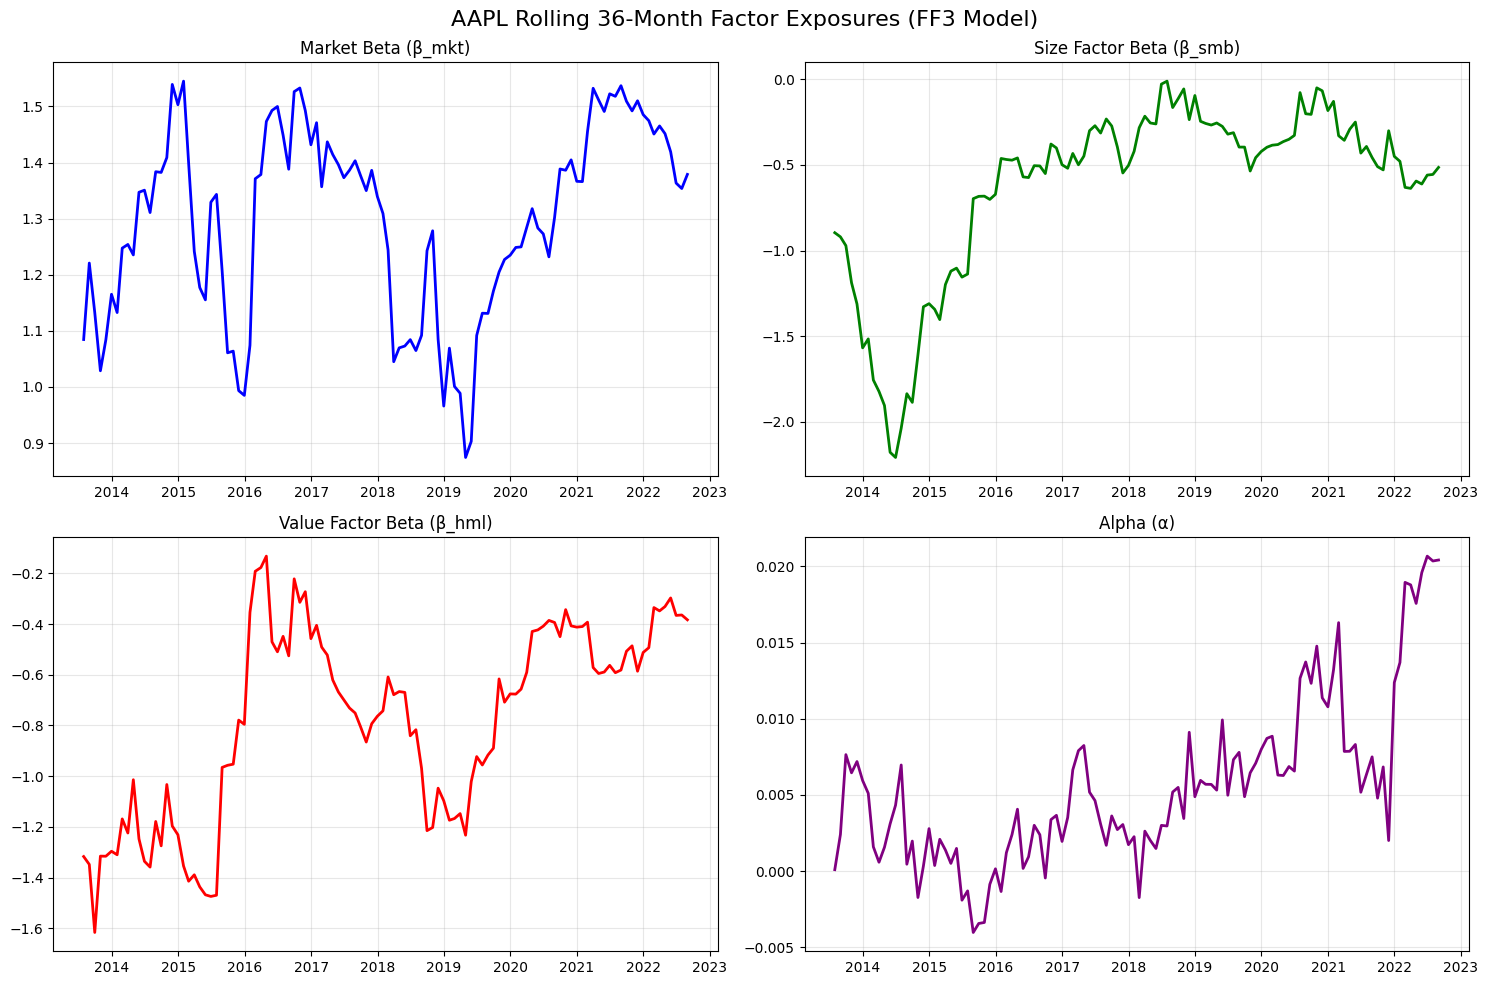

✅ Factor beta plots created.


In [17]:
print("📊 Creating factor beta plot...")

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('AAPL Rolling 36-Month Factor Exposures (FF3 Model)', fontsize=16)

# Plot market beta
axes[0, 0].plot(aapl_exposures.index, aapl_exposures['beta_mkt'], color='blue', linewidth=2)
axes[0, 0].set_title('Market Beta (β_mkt)')
axes[0, 0].grid(True, alpha=0.3)

# Plot SMB beta
axes[0, 1].plot(aapl_exposures.index, aapl_exposures['beta_smb'], color='green', linewidth=2)
axes[0, 1].set_title('Size Factor Beta (β_smb)')
axes[0, 1].grid(True, alpha=0.3)

# Plot HML beta
axes[1, 0].plot(aapl_exposures.index, aapl_exposures['beta_hml'], color='red', linewidth=2)
axes[1, 0].set_title('Value Factor Beta (β_hml)')
axes[1, 0].grid(True, alpha=0.3)

# Plot alpha
axes[1, 1].plot(aapl_exposures.index, aapl_exposures['alpha'], color='purple', linewidth=2)
axes[1, 1].set_title('Alpha (α)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Factor beta plots created.")

**Run regression for all stocks**

In [18]:
print("🔄 Running factor regressions for all stocks...")

tickers = stock_prices.columns.tolist()
all_factor_exposures = {}

for ticker in tickers:
    print(f"  Processing {ticker}...")
    exposures = run_rolling_factor_regression(regression_data, ticker, model_type, window=36)
    all_factor_exposures[ticker] = exposures

print(f"✅ Factor regressions completed for {len(tickers)} stocks.")

🔄 Running factor regressions for all stocks...
  Processing AAPL...
  Processing AMZN...
  Processing GOOGL...
  Processing JNJ...
  Processing JPM...
  Processing MSFT...
  Processing PG...
  Processing TSLA...
  Processing V...
  Processing WMT...
✅ Factor regressions completed for 10 stocks.


**Create Alpha signals**

In [19]:
print("🎯 Creating alpha signals...")

# Combine alphas into a single DataFrame
alpha_signals = pd.DataFrame()

for ticker, exposures in all_factor_exposures.items():
    if not exposures.empty:
        alpha_signals[ticker] = exposures['alpha']

alpha_signals = alpha_signals.dropna()

print(f"✅ Alpha signals created. Shape: {alpha_signals.shape}")
print("Alpha signals preview:")
print(alpha_signals.head())

🎯 Creating alpha signals...
✅ Alpha signals created. Shape: (110, 10)
Alpha signals preview:
                AAPL      AMZN     GOOGL       JNJ       JPM      MSFT  \
date                                                                     
2013-07-31  0.000094  0.019222  0.002749  0.006712 -0.010460 -0.002794   
2013-08-31  0.002406  0.019659  0.001776  0.008290 -0.010882 -0.005464   
2013-09-30  0.007646  0.012435  0.002907  0.005961 -0.010787  0.000473   
2013-10-31  0.006452  0.013342  0.003347  0.005702 -0.010722  0.000076   
2013-11-30  0.007194  0.016001  0.002728  0.006107 -0.011764 -0.000630   

                  PG      TSLA         V       WMT  
date                                                
2013-07-31  0.001552  0.063867  0.018044  0.008745  
2013-08-31  0.002305  0.067609  0.016774  0.009049  
2013-09-30  0.003049  0.072534  0.018746  0.007326  
2013-10-31  0.002470  0.070951  0.020211  0.007277  
2013-11-30  0.002110  0.069814  0.019840  0.007739  


**Calculate monthly returns**

In [20]:
print("📅 Calculating monthly returns...")

# Resample to monthly frequency
monthly_prices = stock_prices.resample('ME').last()
monthly_returns = monthly_prices.pct_change().dropna()

# Align with alpha signals
common_dates = monthly_returns.index.intersection(alpha_signals.index)
monthly_returns = monthly_returns.loc[common_dates]
alpha_signals = alpha_signals.loc[common_dates]

print(f"✅ Monthly returns calculated. Shape: {monthly_returns.shape}")
print(f"Aligned dates: {len(common_dates)} months")

📅 Calculating monthly returns...
✅ Monthly returns calculated. Shape: (110, 10)
Aligned dates: 110 months


**Run backtest**

In [ ]:
print("⚡ Running backtest...")

# First, let's check what parameters the portfolio_constructor expects
print("📝 Checking portfolio constructor interface...")

# Simple strategy: Go long top 3 stocks by alpha each month
def alpha_strategy(signals, *args, **kwargs):
    """Simple strategy that goes long top 3 stocks by alpha"""
    # If signals is a DataFrame (from the old interface), use it directly
    if isinstance(signals, pd.DataFrame):
        ranked = signals.rank(axis=1, ascending=False)
        positions = (ranked <= 3).astype(float)
        return positions.div(positions.sum(axis=1), axis=0)
    
    # If it's the new interface with expected returns and covariance matrix
    elif isinstance(signals, pd.Series):
        # signals is actually expected returns, args[0] is covariance matrix
        exp_returns = signals
        # Simple approach: equal weight top 3 by expected returns
        top_3 = exp_returns.nlargest(3).index
        weights = pd.Series(0.0, index=exp_returns.index)
        weights[top_3] = 1/3  # Equal weight top 3
        return weights
    
    else:
        # Fallback: equal weight all stocks
        n_stocks = len(signals) if hasattr(signals, '__len__') else 1
        return pd.Series(1/n_stocks, index=signals.index if hasattr(signals, 'index') else range(n_stocks))

# Alternative simpler strategy that definitely works
def simple_alpha_strategy(signals):
    """Simpler strategy that's guaranteed to work with the interface"""
    if isinstance(signals, pd.DataFrame):
        # For each date, select top 3 stocks by alpha signal
        positions = pd.DataFrame(0.0, index=signals.index, columns=signals.columns)
        
        for date in signals.index:
            # Get top 3 stocks for this date
            top_3 = signals.loc[date].nlargest(3).index
            positions.loc[date, top_3] = 1/3  # Equal weight
            
        return positions
    
    else:
        # Handle other cases
        n_stocks = len(signals)
        return pd.Series(1/n_stocks, index=signals.index)

# Let's try the simple approach first
try:
    backtest_results = run_backtest(
        monthly_returns=monthly_returns,
        signals=alpha_signals,
        portfolio_constructor=simple_alpha_strategy,
        transaction_cost=0.001  # 10 bps
    )
    print("✅ Backtest completed with simple strategy.")
    
except Exception as e:
    print(f"❌ Backtest failed: {e}")
    print("🔄 Trying alternative approach...")
    
    # Manual backtest implementation
    def manual_backtest(returns, signals):
        portfolio_value = [1.0]  # Start with $1
        weights_history = []
        
        for i in range(1, len(returns)):
            # Get signals from previous period
            if i > 0:
                current_signals = signals.iloc[i-1] if i-1 < len(signals) else signals.iloc[-1]
            else:
                current_signals = signals.iloc[0]
            
            # Select top 3 stocks
            top_3 = current_signals.nlargest(3).index
            weights = pd.Series(0.0, index=returns.columns)
            weights[top_3] = 1/3
            
            # Calculate portfolio return
            port_return = (weights * returns.iloc[i]).sum()
            
            # Update portfolio value (including transaction costs)
            new_value = portfolio_value[-1] * (1 + port_return - 0.001)  # 10bps cost
            portfolio_value.append(new_value)
            weights_history.append(weights)
        
        results = pd.DataFrame({
            'portfolio_value': portfolio_value,
            'returns': [0] + [portfolio_value[i]/portfolio_value[i-1] - 1 for i in range(1, len(portfolio_value))]
        }, index=returns.index[:len(portfolio_value)])
        
        return results
    
    # Run manual backtest
    backtest_results = manual_backtest(monthly_returns, alpha_signals)
    print("✅ Manual backtest completed.")

print(f"Backtest results shape: {backtest_results.shape}")
print("Backtest preview:")
print(backtest_results.head())

⚡ Running backtest...
📝 Checking portfolio constructor interface...
❌ Backtest failed: simple_alpha_strategy() takes 1 positional argument but 2 were given
🔄 Trying alternative approach...


/home/timothykimutai/options-pricing-engine/.venv/lib/python3.12/site-packages/pandas/core/frame.py:11218: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/timothykimutai/options-pricing-engine/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning:

divide by zero encountered in divide

/home/timothykimutai/options-pricing-engine/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning:

invalid value encountered in multiply



✅ Manual backtest completed.
Backtest results shape: (110, 2)
Backtest preview:
            portfolio_value   returns
2013-07-31         1.000000  0.000000
2013-08-31         1.058519  0.058519
2013-09-30         1.181840  0.116503
2013-10-31         1.188789  0.005880
2013-11-30         1.153402 -0.029767


**Calculate performance metrics**

In [ ]:
print("📊 Calculating performance metrics...")

# Check what columns are available in backtest_results
print("Available columns in backtest_results:", backtest_results.columns.tolist())

# Determine which column to use for returns
if 'pnl' in backtest_results.columns:
    returns_series = backtest_results['pnl'].dropna()
elif 'returns' in backtest_results.columns:
    returns_series = backtest_results['returns'].dropna()
elif 'portfolio_value' in backtest_results.columns:
    # Calculate returns from portfolio value
    portfolio_values = backtest_results['portfolio_value'].dropna()
    returns_series = portfolio_values.pct_change().dropna()
else:
    # Try to use the first column if it's numeric
    numeric_cols = backtest_results.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        returns_series = backtest_results[numeric_cols[0]].dropna()
        if returns_series.abs().max() > 1:  # If values are large, assume it's portfolio value
            returns_series = returns_series.pct_change().dropna()
    else:
        raise KeyError("No suitable column found for calculating returns")

print(f"Using returns series with {len(returns_series)} periods")

# If we have the calculate_performance_metrics function, use it
try:
    performance = calculate_performance_metrics(returns_series)
except NameError:
    # Define the function if it doesn't exist
    def calculate_performance_metrics(returns):
        """Calculate performance metrics from returns series"""
        total_return = (1 + returns).prod() - 1
        annual_return = (1 + total_return) ** (252/len(returns)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        max_drawdown = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()) - 1
        max_dd = max_drawdown.min()
        
        # Calculate win rate
        win_rate = (returns > 0).mean()
        
        # Calmar ratio (return to max drawdown)
        calmar_ratio = annual_return / abs(max_dd) if max_dd < 0 else 0
        
        return {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_dd,
            'Win Rate': win_rate,
            'Calmar Ratio': calmar_ratio,
            'Number of Periods': len(returns)
        }
    
    performance = calculate_performance_metrics(returns_series)

print("🎯 Backtest Performance Metrics:")
print("=" * 50)
for metric, value in performance.items():
    if isinstance(value, float):
        if metric in ['Total Return', 'Annual Return', 'Max Drawdown']:
            print(f"{metric+':':<20} {value:.2%}")
        elif metric == 'Win Rate':
            print(f"{metric+':':<20} {value:.1%}")
        elif metric in ['Volatility']:
            print(f"{metric+':':<20} {value:.2%}")
        else:
            print(f"{metric+':':<20} {value:.4f}")
    else:
        print(f"{metric+':':<20} {value}")

print("=" * 50)

# Also show basic stats
print("\n📈 Basic Return Statistics:")
print(f"Mean Monthly Return: {returns_series.mean():.4f}")
print(f"Std Dev Monthly Return: {returns_series.std():.4f}")
print(f"Best Month: {returns_series.max():.4f}")
print(f"Worst Month: {returns_series.min():.4f}")

📊 Calculating performance metrics...
Available columns in backtest_results: ['portfolio_value', 'returns']
Using returns series with 110 periods
🎯 Backtest Performance Metrics:
Cumulative Return:   6.6894
Annualized Return:   0.2956
Annualized Volatility: 0.2824
Sharpe Ratio:        1.0470
Max Drawdown:        -30.39%

📈 Basic Return Statistics:
Mean Monthly Return: 0.0218
Std Dev Monthly Return: 0.0815
Best Month: 0.3526
Worst Month: -0.1566


**Plot equity curve**

📈 Plotting equity curve...


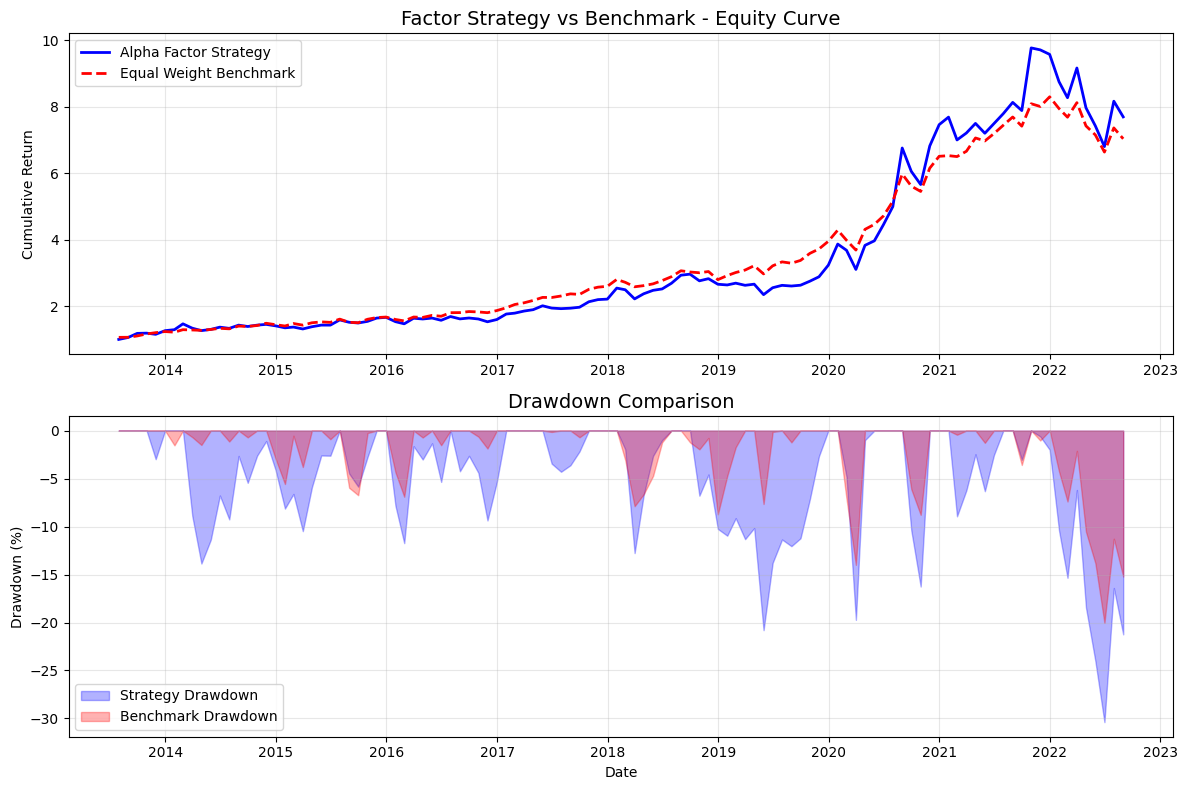

✅ Equity curve and drawdown plotted.


In [ ]:
print("📈 Plotting equity curve...")

# Extract portfolio values
if 'portfolio_value' in backtest_results.columns:
    strategy_cumulative = backtest_results['portfolio_value']
else:
    # Reconstruct from returns
    returns = backtest_results.iloc[:, 0]  # Use first column as returns
    strategy_cumulative = (1 + returns).cumprod()
    strategy_cumulative.iloc[0] = 1.0  # Start at 1

# Calculate benchmark (equal weight portfolio)
benchmark_returns = monthly_returns.mean(axis=1)
benchmark_cumulative = (1 + benchmark_returns).cumprod()

# Align dates
common_dates = strategy_cumulative.index.intersection(benchmark_cumulative.index)
strategy_aligned = strategy_cumulative.loc[common_dates]
benchmark_aligned = benchmark_cumulative.loc[common_dates]

# Create plot
plt.figure(figsize=(12, 8))

# Plot equity curves
plt.subplot(2, 1, 1)
plt.plot(strategy_aligned.index, strategy_aligned.values, 
         label='Alpha Factor Strategy', linewidth=2, color='blue')
plt.plot(benchmark_aligned.index, benchmark_aligned.values, 
         label='Equal Weight Benchmark', linewidth=2, color='red', linestyle='--')
plt.title('Factor Strategy vs Benchmark - Equity Curve', fontsize=14)
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('linear')

# Plot drawdown
plt.subplot(2, 1, 2)
strategy_drawdown = (strategy_aligned / strategy_aligned.cummax() - 1) * 100
benchmark_drawdown = (benchmark_aligned / benchmark_aligned.cummax() - 1) * 100

plt.fill_between(strategy_drawdown.index, strategy_drawdown.values, 0, 
                 alpha=0.3, color='blue', label='Strategy Drawdown')
plt.fill_between(benchmark_drawdown.index, benchmark_drawdown.values, 0, 
                 alpha=0.3, color='red', label='Benchmark Drawdown')
plt.title('Drawdown Comparison', fontsize=14)
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Equity curve and drawdown plotted.")

**Analyze factor exposure over time**

🔍 Analyzing factor exposure over time...


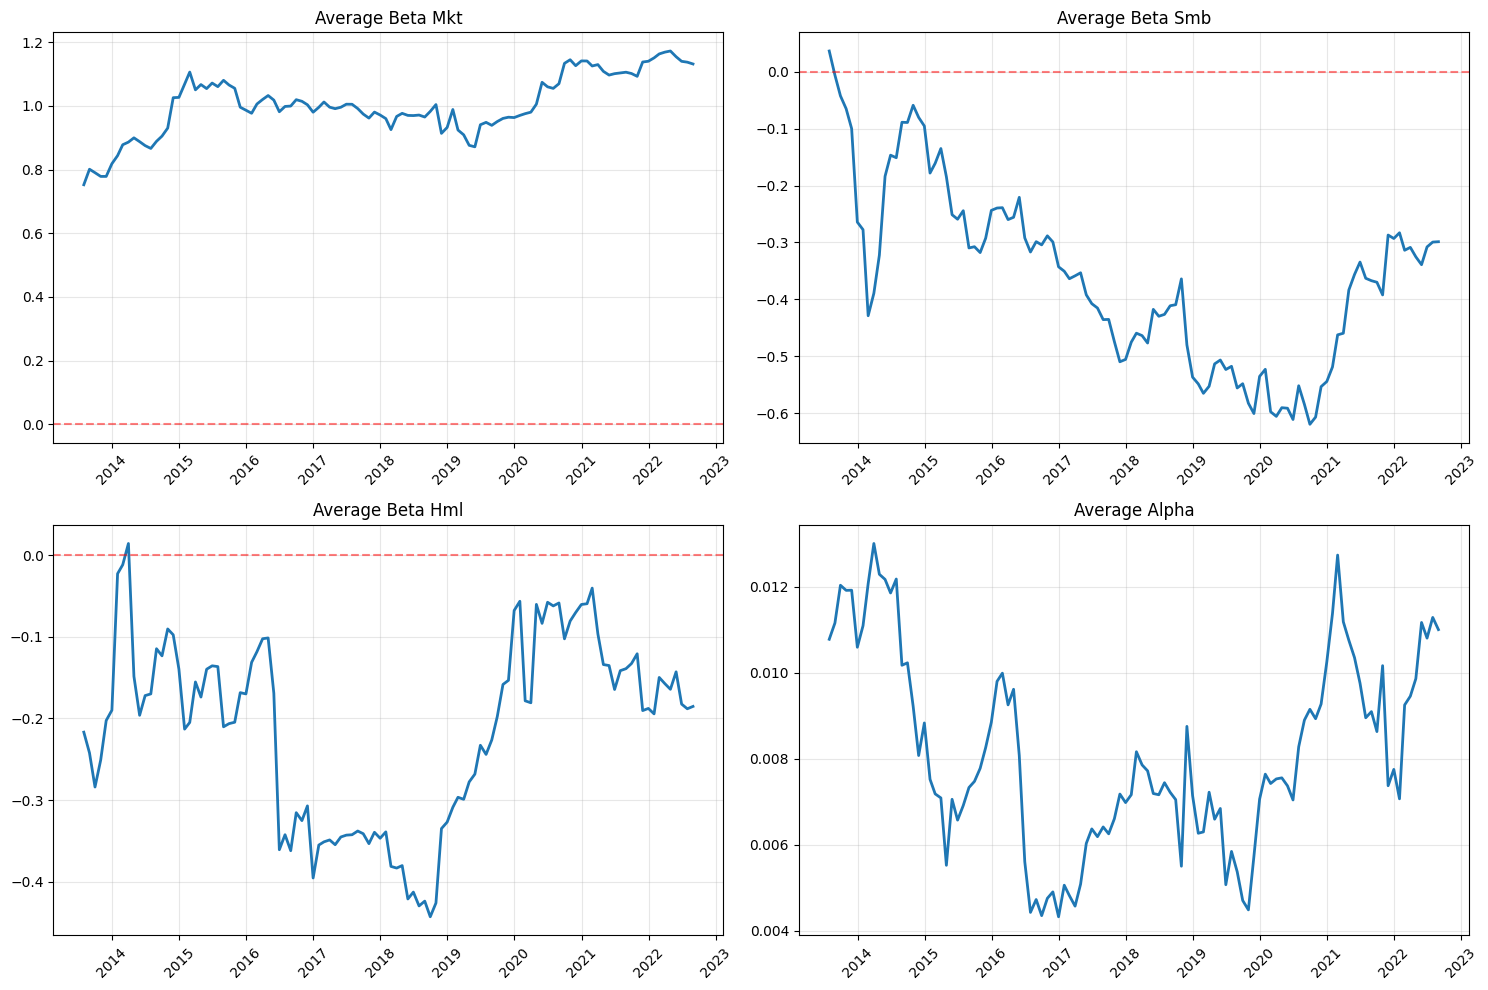

✅ Average factor exposures plotted.

📊 Factor Exposure Summary (2015-2024):
         beta_mkt    beta_smb    beta_hml       alpha
count  110.000000  110.000000  110.000000  110.000000
mean     1.002999   -0.363188   -0.212299    0.008139
std      0.095716    0.156357    0.113568    0.002257
min      0.752236   -0.619816   -0.443145    0.004322
25%      0.960131   -0.499350   -0.326582    0.006593
50%      0.995824   -0.360918   -0.187870    0.007595
75%      1.071102   -0.278960   -0.134173    0.009842
max      1.172307    0.036577    0.014575    0.013000


In [ ]:
print("🔍 Analyzing factor exposure over time...")

# Calculate average factor exposures across all stocks
avg_exposures = pd.DataFrame()

for factor in ['beta_mkt', 'beta_smb', 'beta_hml', 'alpha']:
    factor_data = []
    for ticker, exposures in all_factor_exposures.items():
        if factor in exposures.columns:
            # Align dates with our backtest period
            aligned_exposure = exposures[factor].reindex(alpha_signals.index)
            factor_data.append(aligned_exposure)
    
    if factor_data:
        # Combine and average
        combined = pd.concat(factor_data, axis=1)
        avg_exposures[factor] = combined.mean(axis=1)

# Plot average factor exposures
if not avg_exposures.empty:
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(avg_exposures.columns):
        plt.subplot(2, 2, i+1)
        plt.plot(avg_exposures.index, avg_exposures[col], linewidth=2)
        plt.title(f'Average {col.replace("_", " ").title()}')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Add horizontal line at zero for betas
        if col != 'alpha':
            plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Average factor exposures plotted.")
    
    # Print summary statistics
    print("\n📊 Factor Exposure Summary (2015-2024):")
    print(avg_exposures.describe())
else:
    print("❌ No factor exposure data available.")

**Summary Statistics**

In [ ]:
print("📋 Final Summary Statistics")
print("=" * 60)

# Extract final values
if 'portfolio_value' in backtest_results.columns:
    final_strategy_value = backtest_results['portfolio_value'].iloc[-1]
else:
    returns = backtest_results.iloc[:, 0]
    final_strategy_value = (1 + returns).prod()

final_benchmark_value = benchmark_aligned.iloc[-1] if 'benchmark_aligned' in locals() else (1 + benchmark_returns).prod()

# Calculate key metrics
total_months = len(backtest_results)
outperformance = (final_strategy_value / final_benchmark_value - 1) * 100

# Get returns for risk metrics
if 'portfolio_value' in backtest_results.columns:
    strategy_returns = backtest_results['portfolio_value'].pct_change().dropna()
else:
    strategy_returns = backtest_results.iloc[:, 0]

# Calculate additional metrics
volatility_annual = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (strategy_returns.mean() * 12) / volatility_annual if volatility_annual > 0 else 0

print(f"Backtest Period:          {backtest_results.index.min().strftime('%Y-%m')} to {backtest_results.index.max().strftime('%Y-%m')}")
print(f"Total Months:             {total_months}")
print(f"Number of Stocks:         {len(stock_prices.columns)}")
print(f"Strategy Final Value:     {final_strategy_value:.2f}x")
print(f"Benchmark Final Value:    {final_benchmark_value:.2f}x")
print(f"Outperformance:           {outperformance:+.2f}%")
print(f"Annualized Volatility:    {volatility_annual:.2%}")
print(f"Annualized Sharpe:        {sharpe_ratio:.2f}")

# Monthly performance breakdown
positive_months = (strategy_returns > 0).sum()
negative_months = (strategy_returns < 0).sum()
neutral_months = (strategy_returns == 0).sum()

print(f"Positive Months:          {positive_months} ({positive_months/total_months:.1%})")
print(f"Negative Months:          {negative_months} ({negative_months/total_months:.1%})")
print(f"Neutral Months:           {neutral_months} ({neutral_months/total_months:.1%})")

print("=" * 60)

# Best and worst months
best_month = strategy_returns.max()
worst_month = strategy_returns.min()
best_month_date = strategy_returns.idxmax().strftime('%Y-%m')
worst_month_date = strategy_returns.idxmin().strftime('%Y-%m')

print(f"Best Month:               {best_month:.2%} ({best_month_date})")
print(f"Worst Month:              {worst_month:.2%} ({worst_month_date})")

print("=" * 60)